In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

In [3]:
data = pd.read_csv("./digit_data.csv")

In [4]:
df = pd.get_dummies(data["label"], dtype=int)

In [5]:
data_encoded = pd.concat([data,df], axis = 1)

In [6]:
data_encoded = data_encoded.drop(["label"], axis =1)

In [7]:
data_test = data_encoded[:1000]
data_test.shape
test_y = data_test.iloc[:, 784:]
test_x = data_test.iloc[:,:784]


In [8]:
data_train = data_encoded[1000:]
data_test.shape
train_y = data_train.iloc[:, 784:]
train_x = data_train.iloc[:,:784]

In [9]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

Text(0.5, 1.0, 'The number is 9')

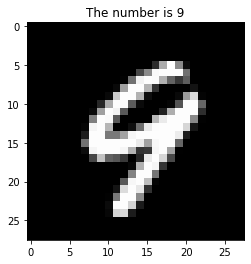

In [10]:
index = int(np.random.random() * data_encoded.shape[0])
plt.imshow(np.array(data.iloc[index, 1:]).reshape((28,28)), cmap="gray")
plt.title(f"The number is {data.iloc[index,0]}")

In [11]:
def initialize_parameters(layer_dims, method ="basic"):
    """Layer dims contains the dimension of each layer in the neural network"""
    parameters = {}

    num_layers = len(layer_dims) # as the input layer is taken as 0
    if(method == "basic"):
        for i in range(1, num_layers):
            parameters[f"W{i}"] = (np.random.random((layer_dims[i-1], layer_dims[i])) - 0.5).T
            parameters[f"b{i}"] = (np.random.random((1, layer_dims[i])) - 0.5).T

    if(method == "xavier_normal"):
        for i in range(1, num_layers):
            fan_in = layer_dims[i-1]
            fan_out = layer_dims[i]
            sd = np.sqrt(2/(fan_in + fan_out))
            parameters[f"W{i}"] = (np.random.normal(0, sd, (layer_dims[i-1], layer_dims[i]))).T
            parameters[f"b{i}"] = np.zeros((1, layer_dims[i])).T

    if(method == "xavier_uniform"):
        for i in range(1, num_layers):
            fan_in = layer_dims[i-1]
            fan_out = layer_dims[i]
            m, n = -np.sqrt(6/(fan_in+fan_out)), np.sqrt(6/(fan_in+fan_out))
            parameters[f"W{i}"] = (np.random.normal(m, n, (layer_dims[i-1],layer_dims[i]))).T
            parameters[f"b{i}"] = np.zeros((1, layer_dims[i])).T
    

    if(method == "he_uniform"):
        for i in range(1, num_layers):
            fan_in = layer_dims[i-1]
            m, n = -np.sqrt(6/(fan_in)), np.sqrt(6/(fan_in))
            parameters[f"W{i}"] = (np.random.normal(m, n, (layer_dims[i-1],layer_dims[i]))).T
            parameters[f"b{i}"] = np.zeros((1, layer_dims[i])).T
    
    if(method == "he_normal"):
        for i in range(1, num_layers):
            fan_in = layer_dims[i-1]
            sd = np.sqrt(2/(fan_in))
            parameters[f"W{i}"] = (np.random.normal(0, sd, (layer_dims[i-1], layer_dims[i]))).T
            parameters[f"b{i}"] = np.zeros((1, layer_dims[i])).T

    return parameters

In [12]:
def relu(z):
    return np.maximum(0, z)

In [13]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True)) # For numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [14]:
def sigmoid(z):
    return 1/ (1+np.exp(-z))

In [15]:
def derivative_sigmoid(z):
    sigmoid = 1/ (1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [16]:
def tanh(z):
    return (np.exp(z) - np.exp(-z))/ (np.exp(z) + np.exp(-z))

In [17]:
def derivative_tanh(z):
    tanh = (np.exp(z) - np.exp(-z))/ (np.exp(z) + np.exp(-z))
    return (1- tanh**2)

In [18]:
def derivative_relu(z):
    return z > 0

In [19]:
def dropout(X, dropout_rate):
    dropout_mask = (np.random.rand(*X.shape) < 1 - dropout_rate)
    X *= dropout_mask / (1 - dropout_rate)
    return X

In [35]:
def forward_pass_test(X, parameters, dropout_rate):
    cache = {}

    num_layers = len(parameters)//2

    A_final = 0

    for i in range(1, len(parameters)//2): 
        W = parameters[f"W{i}"]
        b = parameters[f"b{i}"]

        print(f"W shape : {W.shape}  X shape = {X.shape}")
        Z = np.dot(W, X) + b
        A = relu(Z)
        print(f"A shape : {A.shape}")
        X = A

        # Apply dropout to the hidden layer activations
        A = dropout(A, dropout_rate)

        cache[f"Z{i}"] = Z
        cache[f"A{i}"] = A

        A_final = A
        print(f"A_final shape : {A_final.shape}")


    W_last = parameters[f"W{num_layers}"]
    print(f"W_last shape : {W_last.shape}")
    b_last = parameters[f"b{num_layers}"]


    print(f"A_final shape : {A_final.shape}")
    Z_last = np.dot(W_last, A_final) + b_last
    A_last = softmax(Z_last)

    cache[f"Z{num_layers}"] = Z_last
    cache[f"A{num_layers}"] = A_last

    return cache, A_last

In [56]:
def predict(X, parameters, dropout):
    _, _, _, A2 = forward_pass_test(X, parameters, dropout)
    return np.argmax(A2, axis=0)

In [22]:
def accuracy(train_x, train_y, test_x, test_y, trained_parameters, dropout_rate, epoch,loss):
        predictions_test = predict(test_x.T, trained_parameters, dropout_rate)
        predictions_train = predict(train_x.T, trained_parameters, dropout_rate)
        validation_accuracy = np.mean(predictions_train == np.argmax(train_y.T, axis=0))
        test_accuracy = np.mean(predictions_test == np.argmax(test_y.T, axis=0))
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Validation Accuracy : {validation_accuracy * 100:.2f}%,Test Accuracy: {test_accuracy * 100:.2f}%" )
        return test_accuracy, validation_accuracy

In [49]:
def backward_pass_test(X,Y,parameters,cache):
    m = Y.shape[1]

    temp = {}
    out = {}

    num_layers = len(parameters)//2


    for layer in range(num_layers, 0, -1):
        
        if layer == num_layers:
            temp[f"dZ{layer}"] = cache[f"A{layer}"] - Y
            out[f"dW{layer}"] = np.dot(temp[f"dZ{layer}"], cache[f"A{layer - 1}"].T) /m
            out[f"db{layer}"] = np.sum(temp[f"dZ{layer}"], axis = 1, keepdims = True) / m

        elif layer > 1:
            temp[f"dA{layer}"] = np.dot(parameters[f"W{layer+1}"].T, temp[f"dZ{layer+1}"])
            temp[f"dZ{layer}"] = temp[f"dA{layer}"] * derivative_relu(cache[f"Z{layer}"])
            out[f"dW{layer}"] = np.dot(temp[f"dZ{layer}"], cache[f"A{layer-1}"].T) / m
            out[f"db{layer}"] = np.sum(temp[f"dZ{layer}"], axis = 1, keepdims = True) / m

        else:
            temp[f"dA{layer}"] = np.dot(parameters[f"W{layer+1}"].T, temp[f"dZ{layer + 1}"])
            temp[f"dZ{layer}"] =  temp[f"dA{layer}"] * derivative_relu(cache[f"Z{layer}"])
            # dW1 = np.dot(dZ1, X.T) / m
            # db1 = np.sum(dZ1, axis=1, keepdims=True) / m
            out[f"dW{layer}"] = np.dot(temp[f"dZ{layer}"], X.T) / m
            out[f"db{layer}"] = np.sum(temp[f"dZ{layer}"], axis=1, keepdims=True) / m
            
    # Z1 = cache["Z1"]
    # A1 = cache["A1"]
    # Z2 = cache["Z2"]
    # A2 = cache["A2"]
    # Z3 = cache["Z3"]
    # A3 = cache["A3"]


    # W1 = parameters["W1"]
    # b1 = parameters["b1"]
    # W2 = parameters["W2"]
    # b2 = parameters["b2"]
    # W3 = parameters["W3"]
    # b3 = parameters["b3"]

    # print(f"A2 = {A2.shape}   y = {Y.shape}")
    # dZ3 = A3 - Y
    # dW3 = np.dot(dZ3, A2.T) / m
    # db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    # dA2 = np.dot(W3.T, dZ3)
    # dZ2 = dA2 * derivative_relu(Z2)  # Derivative of ReLU
    # dW2 = np.dot(dZ2, A1.T) / m
    # db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # dA1 = np.dot(W2.T, dZ2)
    # dZ1 = dA1 * derivative_relu(Z1)  # Derivative of ReLU
    # dW1 = np.dot(dZ1, X.T) / m
    # db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    # gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

    gradients = out
    
    return gradients

In [50]:
def cross_entropy_loss(Y_pred, Y_true):
    m = Y_true.shape[1]
    loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    return loss

In [51]:
def update_parameters_test(parameters, gradients, learning_rate):
    cache = {}
    for i in range(1, len(parameters)//2 + 1):
        w = parameters[f"W{i}"]
        b = parameters[f"b{i}"]

        dw = gradients[f"dW{i}"]
        db = gradients[f"db{i}"]

        w -= learning_rate * dw
        b -= learning_rate * db

        cache[f"W{i}"] = w
        cache[f"W{i}"] = b

    return cache

In [52]:
def train(X, Y, hidden_size, output_size, learning_rate, epochs, dropout_rate):
    input_size = X.shape[0]
    parameters = initialize_parameters([input_size, hidden_size, output_size])

    test_accuracy_list = []
    validation_accuracy_list = []
    for epoch in tqdm_notebook(range(epochs), desc="Training progress: "):
        cache, A = forward_pass_test(X, parameters, dropout_rate)
        loss = cross_entropy_loss(A, Y)
        gradients = backward_pass_test(X, Y, parameters, cache)
        print(gradients)
        parameters = update_parameters_test(parameters, gradients, learning_rate)

        if epoch % 1 == 0:
            trained_parameters = parameters
            test_accuracy, validation_accuracy= accuracy(train_x, train_y, test_x, test_y,trained_parameters, dropout_rate, epoch, loss)
            test_accuracy_list.append(test_accuracy)
            validation_accuracy_list.append(validation_accuracy)
    return parameters, test_accuracy_list, validation_accuracy_list

In [53]:
def predict_labels(test_x, test_y, trained_parameters, index):
    value = predict(test_x.T, trained_parameters, 0)
    prediction = value[index]
    actual = np.argmax(test_y[index])
    plt.title(f" Actual : {actual}   Prediction : {prediction}")
    plt.imshow(np.array(test_x[index]).reshape((28,28)), cmap="gray")

In [54]:
def plot_accuracy(values, x_label, y_label, title):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(values)

In [57]:
input_size = train_x.shape[1]
output_size = train_y.shape[1]

hidden_size = 64
learning_rate = 0.001
iterations = 100
epoch = int(100)
dropout_rate = 0  # Example dropout rate of 20% (0.2)

trained_parameters, validation_accuracy, test_accuracy = train(train_x.T, train_y.T, hidden_size, output_size, learning_rate, epoch, dropout_rate)
predictions = predict(test_x.T, trained_parameters, dropout_rate)

# Calculate accuracy
accuracy = np.mean(predictions == np.argmax(test_y.T, axis=0))
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

W shape : (64, 784)  X shape = (784, 41000)
A shape : (64, 41000)
A_final shape : (64, 41000)
W_last shape : (10, 64)
A_final shape : (64, 41000)
{'dW2': array([[-8.11346926e+00,  6.95860881e+01,  4.98113220e+01,
         4.30104498e+00,  8.04747506e+00,  9.95355603e-01,
         1.03172178e+01,  4.83469960e+01,  1.56091266e+00,
         9.67366542e+00,  2.26312364e+01,  3.32494674e+00,
         7.56703255e+01,  3.41959012e+01,  7.15750318e+00,
         7.00838639e+01,  1.78440344e+01,  4.91773095e+01,
         3.90303062e+01,  1.39119175e+02,  4.49653276e+01,
         1.68231159e+01,  7.41632807e+01,  5.36805107e+01,
         1.35849817e+00,  1.28060864e+01,  6.45694906e+01,
         6.11101857e+01,  1.64445130e+02,  7.38923757e+01,
         5.15253510e+01,  2.71643469e+01,  1.06902874e+02,
         5.55736046e+01,  7.62816321e+00,  9.05719084e+01,
        -8.71487064e+00,  4.56950534e+01,  1.49523397e+01,
         9.14755662e+00,  5.81857271e+00,  5.02227882e+01,
         1.92580722e

KeyError: 'b1'